# Model predictions - Online News dataset 📰💫

*K. Fernandes, P. Vinagre and P. Cortez. A Proactive Intelligent Decision
Support System for Predicting the Popularity of Online News. Proceedings
of the 17th EPIA 2015 - Portuguese Conference on Artificial Intelligence,
September, Coimbra, Portugal.*

Nowadays, Blogging and writing articles is a major growing market on the internet. Thanks to easy-to-use tools and friendly tutorials, everyone can be an inspiring writer and develop and share their thoughts on any given subject. Unfortunately, most articles go under the radar as the readers are drowned in too many choices. It is impossible to read the 4 million blog posts every day on the internet. To create and maintain an audience, every writer elaborates some techniques based on their experiences and knowledge. Our goal, here, is to help them confirm or invalidate their thoughts with the use of Visualization, Machine Learning and Deep Learning.

## Librairies 📚🐍

In [ ]:
import pandas as pd
import numpy as np
import time
import plotly.express as px
import matplotlib.ticker as ticker
import seaborn as sns

import pickle
!pip install cchardet
import cchardet
from bs4 import BeautifulSoup, SoupStrainer
import requests
import re

from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb
import sklearn.ensemble as sk_en
import sklearn.linear_model as sk_lm
import tensorflow as tf
from tensorflow import keras
import sklearn.metrics as sklm
from collections import defaultdict
import importlib
import sklearn
from sklearn import svm
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings("ignore")

     |████████████████████████████████| 263 kB 7.5 MB/s 


## Load Data & Overall Overview 🪄

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


In [ ]:
path = '/content/drive/MyDrive/Data/'
data = pd.read_csv(path + "OnlineNewsPopularity.csv")
data.rename(columns=lambda x: x[1:] if len(x)>3 else x, inplace=True)

print(f'Dim: {data.shape}\n\nGeneric information:')
data.info()
print('\n\n5 first lines')
data.head(5)

Dim: (39644, 61)

Generic information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   url                            39644 non-null  object 
 1   timedelta                      39644 non-null  float64
 2   n_tokens_title                 39644 non-null  float64
 3   n_tokens_content               39644 non-null  float64
 4   n_unique_tokens                39644 non-null  float64
 5   n_non_stop_words               39644 non-null  float64
 6   n_non_stop_unique_tokens       39644 non-null  float64
 7   num_hrefs                      39644 non-null  float64
 8   num_self_hrefs                 39644 non-null  float64
 9   num_imgs                       39644 non-null  float64
 10  num_videos                     39644 non-null  float64
 11  average_token_length           39644 non-null  float64
 12  num_key

url  ...  shares
0  http://mashable.com/2013/01/07/amazon-instant-...  ...     593
1  http://mashable.com/2013/01/07/ap-samsung-spon...  ...     711
2  http://mashable.com/2013/01/07/apple-40-billio...  ...    1500
3  http://mashable.com/2013/01/07/astronaut-notre...  ...    1200
4   http://mashable.com/2013/01/07/att-u-verse-apps/  ...     505

[5 rows x 61 columns]

In [ ]:
fig = px.histogram(data, x="shares",
                   title='Articles count per shares section',
                   opacity=0.8,
                   color_discrete_sequence=['indianred'],
                   labels={
                     "shares": "Shares"})
fig.update_layout(yaxis_title="Number of Articles")
fig.show()

Feel free to zoom directly on the graph to see the detailed repartition.

## Preprocessing 💡♻️

For the preprocessing part, there are several issues we need to solve to enable our data to be used as model input data without **misrepresenting it and leading to aberrant predictions**.

*   Firstly, we need to clean our data from its **illogical values** such as rate equal to 701 instead of being included between 0 and 1. But also, worst and average keywords shares being negative which is non-sense since you can't share *negatively* on Mashable, or content with 0 words in it.

*   Then, as observed on the graph above, the dataset includes **severe outliers** and non-normal distribution. Indeed, in the tremendous amount of articles on Mashable, only few articles become really famous and shared (over 8000 shares). Thus, to flatten the curve and avoid the less-known articles to be *overwhelmed* by the hyped ones, we **apply a logarithm** on the output variable.

*   However, some outliers still remain, especially while looking at the **maximum value compared the 3rd Quartile** on specific predictors (e.g *kw_max_min - Q3=1000 | max=298400*). Thus, to **continue the outliers** treatment while preprocessing the data, we need to **split our dataset** to consider it as real brand-new values, not knowing any statistical information on it. After, we use *LocalOutlierFactor* library, allowing us to detect outliers by measuring the **local deviation of the density** of a given sample with **respect to its neighbors** (100 neighbors - Minkowski distance).

*   Finally, we use a *RobustScaler* from *sklearn.preprocessing* library taking into account **InterQuartile Range instead of MinMax Range** to scale our variables that are not already rates or binary predictors.



In [ ]:
data.rename(columns={'self_reference_avg_sharess': 'self_reference_avg_shares'}, inplace=True)
data['kw_min_min']= [x if x>0 else 0 for x in data['kw_min_min']]
data['kw_avg_min']= [x if x>0 else 0 for x in data['kw_avg_min']]
data['kw_min_avg']= [x if x>0 else 0 for x in data['kw_min_avg']]
data.drop([31037], inplace=True) # Article with 701 n_unique_tokens
data = data.loc[data["n_tokens_content"]!=0]

In [ ]:
data['shares'] = np.log(data['shares'])
print(data.shape)

(38462, 61)


However, just before going on with the preprocessing, we need to include our **newly-created variables**.

### Web Scrapping Authors 🕸️✏️

During our research, we found that **playing the numbers game** was very efficient. This means that **the more articles you post, the more likely you are to have one of them popular**. Neetzan Zimmerman, who the Wall Street Journal called possibly “the most popular blogger working on the Web today”, shared in an interview with HubSpot.comthat, he **posts 10 to 15 times per day**. Not every post went viral, but the larger the volume of stories, the greater the chances of one taking off.

Thus, to study the impact of the number of articles written by an author of the shares, we decided to **scrap the author's names directly from Mashable.com** with *BeautifulSoup*, using *SoupStrainer* and *cchardet* librairy to fasten it. Reaching ~2 requests per second, it took almost 8h to get everything. From here, we created a **new variable** called *same_author* compiling the **number of articles done by the same author**.

Issues encountered:

*   Almost **2sec per request** at the beginning - Solved with *SoupStrainer* and *cchardet* librairy.
*   **Spyder crashing or Mashable.com aborting connections** due to too many requests - Solved by saving the author's list to a **pickle file every 50** new.

In [ ]:
def author_date(url):
  page = requests.get(url)
  strainer_author = SoupStrainer('a', attrs={"class": "underline-link"})
  soup = BeautifulSoup(page.content, 'lxml', parse_only=strainer_author)
  try:
    author = soup.get_text(strip=True)
  except:
    author='Unknown'
  return author

In [ ]:
authors=[]
for i in data.index[36761:]:
    authors.append(author_date(data['url'][i]))
    if len(authors)%50 == 0:
        print(len(authors))
        with open(path+"authors.txt", "wb") as fp:   #Pickling
            pickle.dump(authors, fp)

In [ ]:
with open(path+"authors.txt", "rb") as fp:   # Unpickling
    authors = pickle.load(fp)
data['author']=authors

In [ ]:
same_author = dict(data['author'].value_counts())
data['same_author'] = list(map(lambda x: same_author[x], data['author']))

In [ ]:
mean_shares = data.groupby(['author']).mean()[['same_author', 'shares']]
mean_shares['author'] = mean_shares.index
mean_shares.shares= np.exp(mean_shares.shares)
mean_shares= mean_shares[mean_shares['same_author']>200]
fig = px.scatter(mean_shares, x='same_author', y='shares', color='shares',
                 trendline="ols", hover_name="author", hover_data=["same_author", "shares"],
                 title='Mean shares depending on the number of articles written by a unique author')
fig.show()

As we can see, the trendline for the author having at least 200 articles **doesn't confirm our theory**. This can be partially explained by the fact that the people that post almost 2 articles a day during 2 years such as Sam Laird **may not focus on the quality** of their contents rather than quantity. Moreover if **they don't actively promote** it on the social medias for example, the must not be really famous anyways.

In [ ]:
data["optimal_length"] = [1 if (i >1000) & (i<3000) else 0 for i in data.n_tokens_content]

In [ ]:
data.describe()

timedelta  n_tokens_title  ...   same_author  optimal_length
count  38462.000000    38462.000000  ...  38462.000000    38462.000000
mean     360.391425       10.382455  ...    599.789403        0.127060
std      212.772883        2.113816  ...    465.879606        0.333045
min        8.000000        2.000000  ...      1.000000        0.000000
25%      174.000000        9.000000  ...    188.000000        0.000000
50%      347.000000       10.000000  ...    499.000000        0.000000
75%      547.000000       12.000000  ...    974.000000        0.000000
max      731.000000       23.000000  ...   1473.000000        1.000000

[8 rows x 62 columns]

Our goal here is to predict whether an article is going to be **popular or not prior its publication**. Then, it is important **not to take into account any timeline information** about the article. Indeed, the more an article stays online, the more likely it is to be shared multiple times !

In [ ]:
data_X = data.drop(['url', 'shares', 'timedelta', 'author'], axis=1)
data_Y = data['shares']
X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, test_size=0.20, random_state=500)

In [ ]:
lof = LocalOutlierFactor(n_neighbors = 100)
yhat = lof.fit_predict(X_train)
mask = yhat != -1

In [ ]:
X_train['non_outliers']=mask
X_train = X_train[X_train['non_outliers']]

y_train=y_train[X_train.index]
X_train.drop(['non_outliers'], axis=1, inplace=True)
print(X_train.shape)

(28193, 60)


In [ ]:
X_train.drop(['n_non_stop_words', 'kw_max_max'], axis=1, inplace=True)
X_test.drop(['n_non_stop_words', 'kw_max_max'], axis=1, inplace=True)

In [ ]:
rob_scale = preprocessing.RobustScaler()
col_scale = ['n_tokens_title', 'n_tokens_content', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
             'average_token_length', 'num_keywords', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max',
             'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares',
             'self_reference_max_shares', 'self_reference_avg_shares', 'same_author']
rob_scale.fit(X_train[col_scale])
X_train[col_scale] = rob_scale.transform(X_train[col_scale])
X_test[col_scale] = rob_scale.transform(X_test[col_scale])
X_train.describe()

n_tokens_title  n_tokens_content  ...   same_author  optimal_length
count    28193.000000      28193.000000  ...  28193.000000    28193.000000
mean         0.138817          0.297903  ...      0.126955        0.127372
std          0.704251          0.984621  ...      0.590403        0.333395
min         -2.333333         -0.869099  ...     -0.633588        0.000000
25%         -0.333333         -0.347639  ...     -0.395674        0.000000
50%          0.000000          0.000000  ...      0.000000        0.000000
75%          0.666667          0.652361  ...      0.604326        0.000000
max          4.333333         14.510730  ...      1.239186        1.000000

[8 rows x 58 columns]

In [ ]:
pca = PCA(n_components=5)
pca.fit(X_train)
print(pca.explained_variance_ratio_)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

[0.66053948 0.17210568 0.05195888 0.03951311 0.03520168]


## Data Visualization & Exploration 🗺️❓

In [ ]:
data.drop(['url', 'author'], axis=1, inplace=True)

### Shares Distribution 📊🪝

Our target variable is the number of shares per article. We want to know a little more about its distribution in our dataset.

#### Original Scale

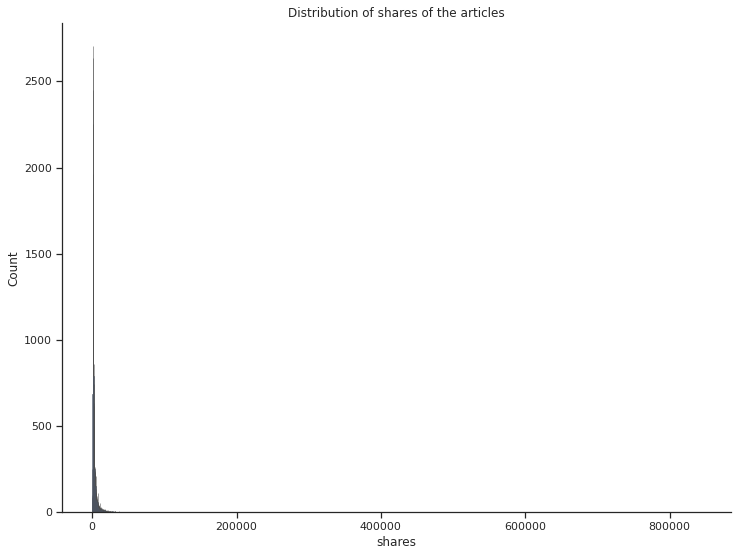

In [ ]:
f, ax = plt.subplots(figsize=(12,9))
sns.despine(f)

sns.histplot(data,x="shares",
    edgecolor=".3",linewidth=.5).set_title("Distribution of shares of the articles")

plt.savefig('shares_articles.png')
plt.show()

This phenomenon is not ruled by a normal distribution. Some Machine Learning models as the Logistic and Linear Regression or the Gaussian Naive Bayes have a Gaussian assertion and might not work in that way. To predict new results we could use other models who don't need the normality of their data like notably the decision trees. Or we could use a logarithmic transformation to flatten the number of shares. 

#### Logarithmic Scale

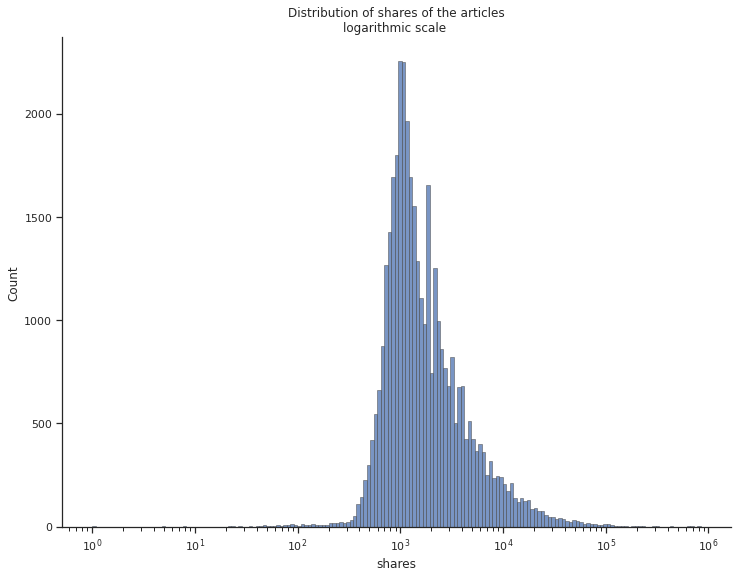

In [ ]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(12,9))
sns.despine(f)

sns.histplot(
    data,
    x="shares", 
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
    bins=175
).set_title("Distribution of shares of the articles\nlogarithmic scale ")

plt.savefig('shares_articles_log.png')

plt.show()

### What does make an article successful on Mashable ? 🌟📜

#### Should we use our emotions or stick only to the facts ?

Based on our research, we found that writers must face a dilemma between their role as author and journalist against themselves. They have to choose to let their emotions on a subject speak or rise above the fray.

This process implies NLP techniques and precisely the notion of subjectivity. When facing a corpus, the subjectivity tries to quantify the emotional implication of the author and their personal opinion against the facts. It's a float that lies in the range of [0,1] where 0 represents the maximum of facts and 1 the maximum opinion.

Fortunately, we have a variable that contains this valuable information in our dataset `global_subjectivity` . 

The following graph compares the difference of numbers between successful and unsuccessful articles for a given subjectivity.

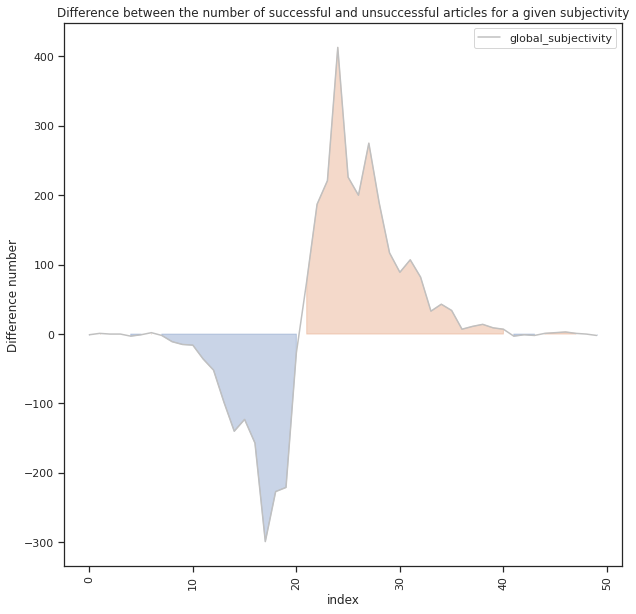

In [ ]:
temp = data.copy()

temp_df=pd.DataFrame(pd.cut(data.loc[data["shares"]>1400]["global_subjectivity"],bins=50).value_counts().sort_index()-pd.cut(data.loc[data["shares"]<1400]["global_subjectivity"],bins=50).value_counts().sort_index()).reset_index()
temp_df["index"] = temp_df.index/50

ax = temp_df.plot(x="index",y="global_subjectivity",rot=90,figsize=(10,10),color="silver")
ax.fill_between(temp_df.index,temp_df["global_subjectivity"],where = temp_df['global_subjectivity']<0,color="C0",alpha=0.4)
ax.fill_between(temp_df.index,temp_df["global_subjectivity"],where = temp_df['global_subjectivity']>0,color="C1",alpha=0.4)
ax.set_title('Difference between the number of successful and unsuccessful articles for a given subjectivity')
ax.set_ylabel("Difference number")

plt.savefig('subjectivity.png')

plt.show()

As we can see above, we have a switch around 0.4 from negative values to a positive one. It simply means that there are more successful articles than unsuccessful ones when the subjectivity exceeds 0.4.

To conclude, if our new writer wants to write the average successful article, he should let his emotions speak.

This confirms the intuition that stories that evoke intense emotions tend to drive popularity. The content that triggers “high-arousal” emotions performs better online whereas content that sparks “low-arousal” emotions is less viral.
This phenomenon could be a starting point to explain why fake news spread more rapidly since they are focused on emotions and sensationnal rather than objectivity and facts. 


#### Should we transmit positive or negative news ?

Now that we know that emotions play a role in the success of the article, we need to know which one we should use. Should our writer be a messenger for bad or good news ? 

Once again, we can use NLP techniques and this time the polarity. The polarity quantifies the overall emotion in a corpus whether it is positive or negative. It is a float contained in the interval [-1,1] where -1 is the extreme negative and 1 the extreme positive.

The polarity has also been computed in the research paper in the `global_sentiment_polarity` column.

The following graph represents the repartition between the successful and unsuccessful articles. The more a category is represented the more it is high.

In [ ]:
temp_data=data
temp_data["success"]=  [1 if i>1400 else 0 for i in temp_data["shares"]]
px.histogram(temp_data,x="global_sentiment_polarity",color="success",barmode="overlay",title="Distribution of articles classified by success depending on polarity ")

Like subjectivity there is a switch between the higher number between the successful articles and the unsuccessful ones. It seems like a better idea for our writer to use positive emotions.

For the professors' Jonah Berger and Katherine L. Milkman : “positive content is more viral than negative content”

#### On what topics should you write ?

Of course, what interests you. But if your only goal as a writer is to become successful there is probably some thematics that are more viral in Mashable and their audience. 

For example, if an author loves to write about home design, it will not find much success in a teenage site since it's not their main interest. On the opposite, a business article will probably find an audience in a site mostly followed by entrepreneurs


In [ ]:
channel_dict = {'lifestyle':1,
               'entertainment':2,
               'bus':3,
               'socmed':4,
               'tech':5,
               'world':6
              }

In [ ]:
channel= data[["data_channel_is_lifestyle","data_channel_is_entertainment","data_channel_is_bus","data_channel_is_socmed","data_channel_is_tech","data_channel_is_world"]]
channel.rename(columns=lambda x: x[16:], inplace=True)
channel= pd.DataFrame(channel.idxmax(axis=1))
channel['shares'] = data['shares']
#sinon y a des valeurs à 80000 et ca devient illisible
channel = channel.loc[channel["shares"]<8000]
channel["med"] = channel[0].map(dict(channel.groupby(0)["shares"].median()))
channel["sort"] = channel[0].map(channel_dict)
channel.sort_values("sort",inplace=True)
channel.rename({0:"topic"},axis=1,inplace=True)

In [ ]:
fig= px.box(channel, y="shares", facet_col="topic", color="topic",
             boxmode="overlay", points='suspectedoutliers',title="Number of Shares depending on the topic")
for i in range(0,len(channel_dict)):
  fig.update_traces(name=list(channel_dict.keys())[i], jitter=0, col=channel_dict[list(channel_dict.keys())[i]])
                    
fig.show()

The channel is an important factor as we notice multiple gaps. The articles in the channel world and entertainment did not attract much enthusiasm and have the lowest median share.

The lifestyle and technology channel follow up with good results and median above the symbolic limit of 1400. It means that more than 50% of those articles were considered successful.

Finally, the social media channel is the grand winner in terms of popularity : the first quartile is equal to 1300 which means almost 75% of articles in this channel are successful.

#### Brief News or Detailed Explanations ?

Writing is a time-consuming activity but is it worth it ?

Should you spend your time writing about every aspect of the subject or just give the main points to your subjects?

The answer seems in-between and most researchers agreed to an optimal length between 1000 and 3000 words. Most american people read about 250 words/min and the average time given to an article is around 7 minutes. Of course, those numbers are overgeneralised and can vary from site to site.

In [ ]:
temp_data=data
temp_data["success"]=  [1 if i>1400 else 0 for i in temp_data["shares"]]
temp_data["length"] = ["optimal length" if (i >1000) & (i<3000) else "other length" for i in temp_data.n_tokens_content]
temp_data = pd.DataFrame(pd.crosstab(temp_data["success"],temp_data["length"])/pd.DataFrame(pd.crosstab(temp_data["success"],temp_data["length"],)).sum()*100)
temp_data.style.background_gradient(axis =1,cmap='BuGn')
#pd.DataFrame(pd.DataFrame(pd.crosstab(temp_data["success"],temp_data["length"],))/pd.DataFrame(pd.crosstab(temp_data["success"],temp_data["length"],)).sum()).background_gradient( cmap='BuGn')
#px.histogram(temp_data,x="length",color="success")

In this table, it is clear that you statistically have more chance to produce a successful article (54%) if its length is between 1000 and 3000 words.

#### The length is all about the subject

Even with the table above, we can assume that the length will not be the same depending on the topic. Of course, some themes are more likely to increase the number of words to make the article cohesive and drive popularity.

In [ ]:
channel= data[["data_channel_is_lifestyle","data_channel_is_entertainment","data_channel_is_bus","data_channel_is_socmed","data_channel_is_tech","data_channel_is_world"]]
channel.rename(columns=lambda x: x[16:], inplace=True)
channel= pd.DataFrame(channel.idxmax(axis=1))
channel['shares'] = data['shares']
#GET RID OF THE OUTLIERS
channel = channel.loc[channel["shares"]<8000]
channel["med"] = channel[0].map(dict(channel.groupby(0)["shares"].median()))
channel["sort"] = channel[0].map(channel_dict)
channel["word_count"] = data["n_tokens_content"]
channel.sort_values("sort",inplace=True)
channel.rename({0:"topic"},axis=1,inplace=True)

In [ ]:
fig = px.scatter(
    channel, y='shares', x='word_count', color='topic', opacity=0.65,
    trendline='ols', trendline_color_override='darkblue',title= "Number of Share depending on the number of words per subject"
)
fig.show()

The first thing to notice is that we obtain very different linear regression between the themes. Unfortunately, the R square is not significant enough since we only use one variable which is the number of words in the article. 

However, we notice some differences between the themes that are interesting. 
First of all, the coefficient is near 0 for social network, entertainment and world related articles. It means that for those categories, the number of words does not matter. 
Then, the lifestyle, business and technology articles are more significant with a positive coefficient. It tells us that writing longer articles in those categories is a good idea. Those topics can have a direct impact on our daily life, so it makes sense that we are willing to spend more time and more words on those.

Once our new writer will know which themes will be discussed in his text, he'll need to aim between 1000 and 3000 words. If it is business, tech or lifestyle related, approaching the upper limit could be a plus.

#### What about vocabulary ?

Now that our writer has a better idea of what to write, he just needs to do one thing : write.

But should he use long elaborated words or should he stick to a conversational language? 

The graph beside will help him to decide. It is a direct comparison between the number of shares per article and the average length of the words. Of course, the higher the average is, the higher the words are elaborated and digress from speaking language.

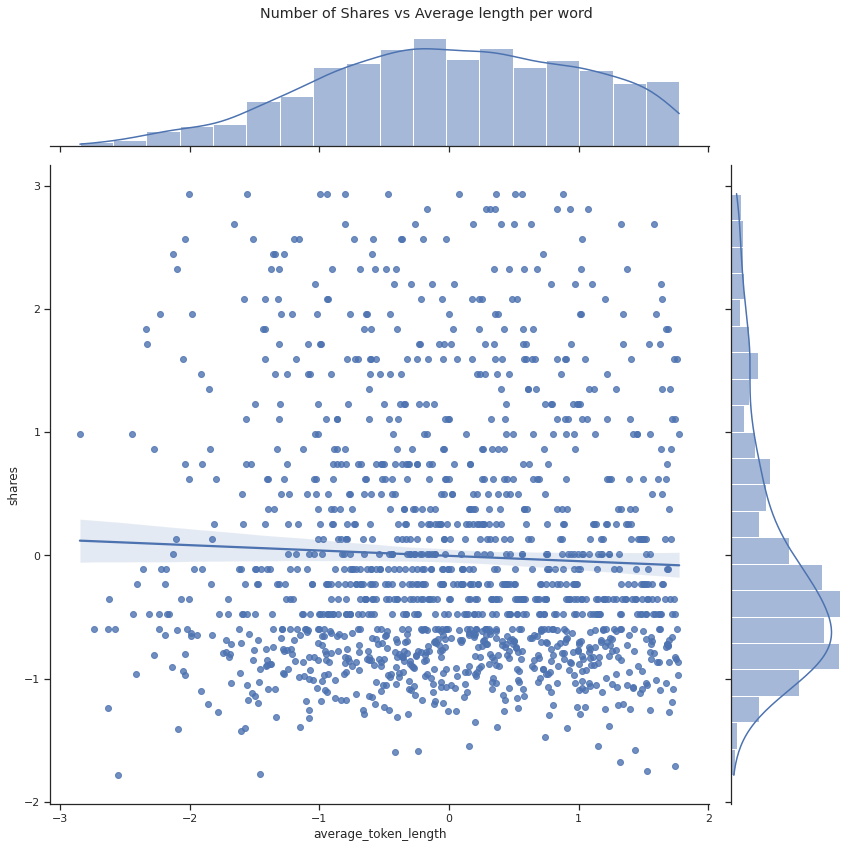

In [ ]:
data2 = data.loc[ (data["shares"]<4000) & (data["average_token_length"]>4.0) & (data["average_token_length"]<5.0)]
norm_data = (data2-data2.mean())/data2.std()
norm_data["success"] = [1 if i>1400 else 0 for i in data2["shares"]]

p =sns.jointplot(data=norm_data.sample(frac=0.05),x="average_token_length", y="shares", kind="reg",height=12)
p.fig.suptitle("Number of Shares vs Average length per word")
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95) # Reduce plot to make room


plt.savefig('avg_word.png')

plt.show()

As we can there's a negative regression between the two factors. It implies that the number of shares decreases as the average of letter per words increases. Unfortunately, the relation is not really significant but it can give us an overall tendency.

Our writer should write in a way that is understandable by everyone. It seems logical that an article readable by everyone will attract more audience than one filled with niche vocabulary. Also, the message that our writer tries to deliver will be more easily heard.

#### Should you include Images ?

Great ! Our article is done now, our writer wrote it overnight and is satisfied with his content. Now, he is wondering about including images but he is not convinced about their impact.

Let's draw a difference graph between the successful and unsuccessful articles considering the number of images.

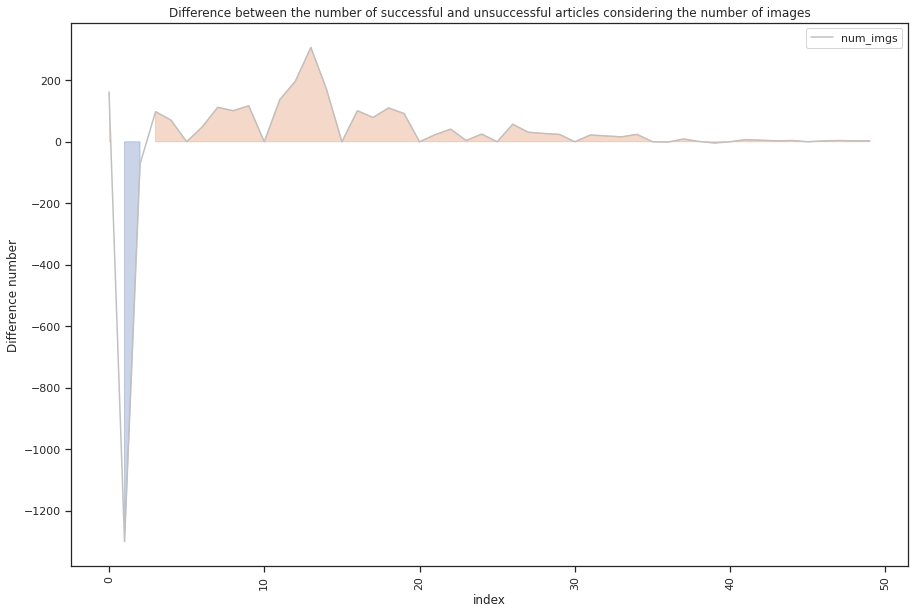

In [ ]:
img_data = data.copy()
#img_data["success"]=  [1 if i>1400 else 0 for i in img_data["shares"]]
img_data = img_data.loc[img_data["num_imgs"]<=40]

temp_df=pd.DataFrame(pd.cut(img_data.loc[img_data["shares"]>1400]["num_imgs"],bins=50).value_counts().sort_index()-pd.cut(img_data.loc[img_data["shares"]<1400]["num_imgs"],bins=50).value_counts().sort_index()).reset_index()#
temp_df["index"] = temp_df.index


ax = temp_df.plot(x="index",y="num_imgs",rot=90,figsize=(15,10),color="silver")
ax.fill_between(temp_df.index,temp_df["num_imgs"],where = temp_df['num_imgs']>-10,color="C1",alpha=0.3)
ax.fill_between(temp_df.index,temp_df["num_imgs"],where = temp_df['num_imgs']<0,color="C0",alpha=0.3)
ax.set_title('Difference between the number of successful and unsuccessful articles considering the number of images')
ax.set_ylabel("Difference number")

plt.savefig('img.png')

plt.show()

The more images are displayed the more chance you have to be popular as we see an impressive switch around 2 images. 

We live in a society filled with images and videos all the time and we are now more accustumed to reading descriptions on Instagram than long text daily. Of course, the book industry is still well alive but on the subway, the "graphic" social media have replaced the novel for the most part. We are now used to seeing images alongside texts.

Also, images can be a great help to memorize information and concept written in the article.

For all those reasons, our writer should include images in his article. The content of the image is also fundamental but we do not possess data on them. It could be a great follow-up to this work.

#### When should you publish ?

Finally, our article is done and our writer can't wait to let the world know his work. However, he is not sure when to publish it ?

Does the day of the publication influence how well an article perform ? It can clearly be a factor as most people could be too busy to read at a certain period. Also, the weekend can have an impact since we have more free time.

In [ ]:
week_dict= {  'monday':1,
               'tuesday':2,
               'wednesday':3,
               'thursday':4,
               'friday':5,
               'saturday':6,
               'sunday':7
              }

In [ ]:
weekday = data[["weekday_is_monday","weekday_is_tuesday","weekday_is_wednesday","weekday_is_thursday","weekday_is_friday","weekday_is_saturday","weekday_is_sunday"]]
weekday.rename(columns=lambda x: x[11:], inplace=True)
weekday = pd.DataFrame(weekday.idxmax(axis=1))
weekday['shares'] = data['shares']
#sinon y a des valeurs à 80000 et ca devient illisible
weekday = weekday.loc[weekday["shares"]<8000]
weekday["med"] = weekday[0].map(dict(weekday.groupby(0)["shares"].median()))
weekday["sort"] = weekday[0].map(week_dict)
weekday.rename({0:"day"},axis=1,inplace=True)
weekday.sort_values("sort",inplace=True)

In [ ]:
fig = px.box(weekday, y="shares", facet_col="day", color="day",
             boxmode="overlay", points='suspectedoutliers',title="Number of shares depending on the day of publication")
for i in range(0,len(week_dict)):
  fig.update_traces(name=list(week_dict.keys())[i], jitter=0, col=week_dict[list(week_dict.keys())[i]])
fig.show()

As we can see, there is a difference between weekdays and the weekend. The median is 1800 shares per article during the weekend and 1300 during the week.

It means that the median article is far above the success median when it is published during the week-end !

To conclude, it's an advantage to post during the weekend in Mashable. It is not true for all platforms as we have seen that it is better to post on Tuesday and Thursday on LinkedIn for example.

Our new writer has now all the tips and keys to create his successful article on the Mashable website.

Only thing to change to make smash hit is the topic !


## Model Training & Performance Evaluation 🧮🎖️

In [ ]:
y_test_binary = np.where(y_test>=np.log(1400), 1, 0)
y_train_binary = np.where(y_train>=np.log(1400), 1, 0)

In [ ]:
def get_sklearn_algorithms (verbose = False):
  algos = defaultdict(list)
  if verbose : print(dir(sklearn))
  for nom_module in dir(sklearn):
    if verbose : print(nom_module)
    try:
      to_import = "sklearn.%s"%nom_module
      module = importlib.import_module(to_import)
      for nom_fonction in dir(module):
        fonction = getattr(module,nom_fonction)
        if hasattr(fonction,"fit"):
          if verbose : print(" nom algorithme =",nom_fonction)
          algos [nom_module].append(fonction)
    except Exception as e:
      if verbose : print(e)
    if verbose : print("="*30)
  return algos

In [ ]:
algos = get_sklearn_algorithms()
for key in algos.keys():
  print("\n===>",key)
  algos_ = []
  for algo in algos[key]:
    classe_algo = str(algo)
    nom_algo = classe_algo[str(classe_algo).rfind(".")+1:str(classe_algo).rfind("")]
    algos_.append(nom_algo)
  print(",".join(algos_))


===> decomposition
DictionaryLearning'>,FactorAnalysis'>,FastICA'>,IncrementalPCA'>,KernelPCA'>,LatentDirichletAllocation'>,MiniBatchDictionaryLearning'>,MiniBatchSparsePCA'>,NMF'>,PCA'>,SparseCoder'>,SparsePCA'>,TruncatedSVD'>

===> dummy
DummyClassifier'>,DummyRegressor'>

===> ensemble
AdaBoostClassifier'>,AdaBoostRegressor'>,BaggingClassifier'>,BaggingRegressor'>,ExtraTreesClassifier'>,ExtraTreesRegressor'>,GradientBoostingClassifier'>,GradientBoostingRegressor'>,HistGradientBoostingClassifier'>,HistGradientBoostingRegressor'>,IsolationForest'>,RandomForestClassifier'>,RandomForestRegressor'>,RandomTreesEmbedding'>,StackingClassifier'>,StackingRegressor'>,VotingClassifier'>,VotingRegressor'>

===> linear_model
ARDRegression'>,BayesianRidge'>,ElasticNet'>,ElasticNetCV'>,GammaRegressor'>,HuberRegressor'>,Lars'>,LarsCV'>,Lasso'>,LassoCV'>,LassoLars'>,LassoLarsCV'>,LassoLarsIC'>,LinearRegression'>,LogisticRegression'>,LogisticRegressionCV'>,MultiTaskElasticNet'>,MultiTaskElasticNetCV'

In [ ]:
algos['decomposition'] = []
algos['neighbors'] = []
algos['preprocessing'] = []
algos['model_selection'] = []

In [ ]:
performances = {}
modeles_a_tester = []
classes_de_modeles_a_tester = algos.keys()
best_algorithm = 0
best_perf = 0
for classe_de_modeles in classes_de_modeles_a_tester :
  modeles_a_tester.extend(algos[classe_de_modeles])

for pointeur_vers_algo in modeles_a_tester :
  try:
    algorithme = pointeur_vers_algo()
    doc = algorithme.__doc__
    name = doc[:min(doc.find(":"),28)].strip()
    print(name)
    if 'regress' in name.lower():
      print('Regression Model')
    else:
      algorithme.fit(X_train,y_train_binary)
      performance = algorithme.score(X_test,y_test_binary)
      print(performance)

      if performance > best_perf:
        best_algorithm = algorithme
        best_perf = performance
      
      if 0 < performance and performance < 1 :
        performances[name] = [performance]
  
  except Exception as e: 
    print(str(e)[:50])
  print("="*30)

DummyClassifier is a cl
0.5256726894579488
Regressor that makes predict
Regression Model
An AdaBoost classifier.
0.6624203821656051
An AdaBoost regressor.
Regression Model
A Bagging classifier.

    A
0.6257636812686859
A Bagging regressor.

    A
Regression Model
An extra-trees classifi
0.6672299493045626
An extra-trees regresso
Regression Model
Gradient Boosting for classi
0.6719095281424672
Gradient Boosting for regres
0.15945777592676202
Histogram-based Gradient Boo
0.6768490835824775
Histogram-based Gradient Boo
0.16428958066195753
Isolation Forest Algori
'IsolationForest' object has no attribute 'score'
A random forest classif
0.6609905108540232
A random forest regress
Regression Model
An ensemble of totally
'RandomTreesEmbedding' object has no attribute 'sc
__init__() missing 1 required positional argument:
__init__() missing 1 required positional argument:
__init__() missing 1 required positional argument:
__init__() missing 1 required positional argument:
Bayesian ARD regressi

In [ ]:
df = pd.DataFrame(performances).T
df.columns=["performance"]
df.performance.sort_values()

Epsilon-Support Vector Regre      0.024720
Cross-validated Orthogonal M      0.054477
Orthogonal Matching Pursuit       0.054477
Cross-validated Least Angle       0.065269
Elastic Net model with itera      0.080173
Linear least squares with l2      0.080340
Lasso linear model with iter      0.080399
Ordinary least squares            0.080436
Lasso model fit with Lars us      0.081780
Cross-validated Lasso, using      0.081800
Gradient Boosting for regres      0.159458
Histogram-based Gradient Boo      0.164290
DummyClassifier is a cl           0.525673
Passive Aggressive Classifie      0.539711
Linear perceptron classifier      0.554010
An extremely randomized tree      0.574418
A decision tree classifier.       0.583387
Nu-Support Vector Classifica      0.613415
A Bagging classifier.\n\n    A    0.625764
Linear Support Vector Classi      0.631093
Linear classifiers (SVM, log      0.647602
C-Support Vector Classificat      0.649422
Classifier using Ridge regre      0.654621
Ridge class

In [ ]:
liste_des_performances = df.performance.values
gains = [0]
for indice,performance in enumerate(liste_des_performances):
  if indice > 0:
    previous_value = liste_des_performances[indice-1]
    current_value = liste_des_performances[indice]
    gain = (current_value - previous_value)/previous_value
    gains.append(round(gain*100,2))
df["gains %"] = gains
df.rename(index={'A Bagging classifier.\n\n    A': 'A Bagging classifier'}, inplace=True)
df = df.drop(df[df.performance < 0.2].index)
df

performance  gains %
DummyClassifier is a cl          0.525673     0.00
Passive Aggressive Classifie     0.539711     2.67
Linear perceptron classifier     0.554010     2.65
An extremely randomized tree     0.574418     3.68
A decision tree classifier.      0.583387     1.56
Nu-Support Vector Classifica     0.613415     5.15
A Bagging classifier             0.625764     2.01
Linear Support Vector Classi     0.631093     0.85
Linear classifiers (SVM, log     0.647602     2.62
C-Support Vector Classificat     0.649422     0.28
Classifier using Ridge regre     0.654621     0.80
Ridge classifier with built-     0.654881     0.04
A random forest classif          0.660991     0.93
An AdaBoost classifier.          0.662420     0.22
An extra-trees classifi          0.667230     0.73
Gradient Boosting for classi     0.671910     0.70

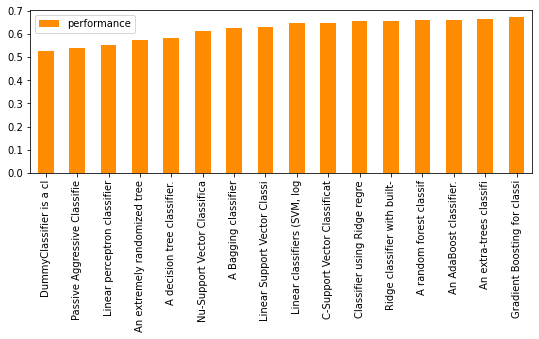

In [ ]:
df = df.drop(['gains %'], axis=1)
fig,axes= plt.subplots(1,1)
fig.set_size_inches(9,3)
df = df.sort_values("performance")
axes.xaxis.set_ticklabels(df.index)
axes.xaxis.set_major_locator(ticker.MultipleLocator(1))
df.plot(kind="bar",rot=90,ax=axes, color='darkorange')
fig.show()

### Logistic Regression 🌊📐

Our base-line model for this study will be the **Logistic Regression**. The logistic regression is a classification algorithm from *sklearn.linear_model* that computes the **probability** that an input X belongs to a class Y. This probability is found using the logistic function which only depends on two parameters. They are estimated via the **Maximum Likelihood Estimation Method** (MLE). Once we know the probability, we **set a threshold** to assign each inputs to a specific class.

Logistic Regression has many advantages, such as:

*   **Really easy** to implement, interpret, and efficient to train.

*   **Less inclined to over-fitting** even in high dimensional datasets thanks to the **Regularization** (L1 and L2) techniques.

However, we also have to consider that it requires **average or no multicollinearity** between independent variables, which is our case looking at the correlation heatmap. But it is **tough to obtain complex relationships** using logistic regression. More powerful and compact algorithms such as Neural Networks can **easily outperform this algorithm**.

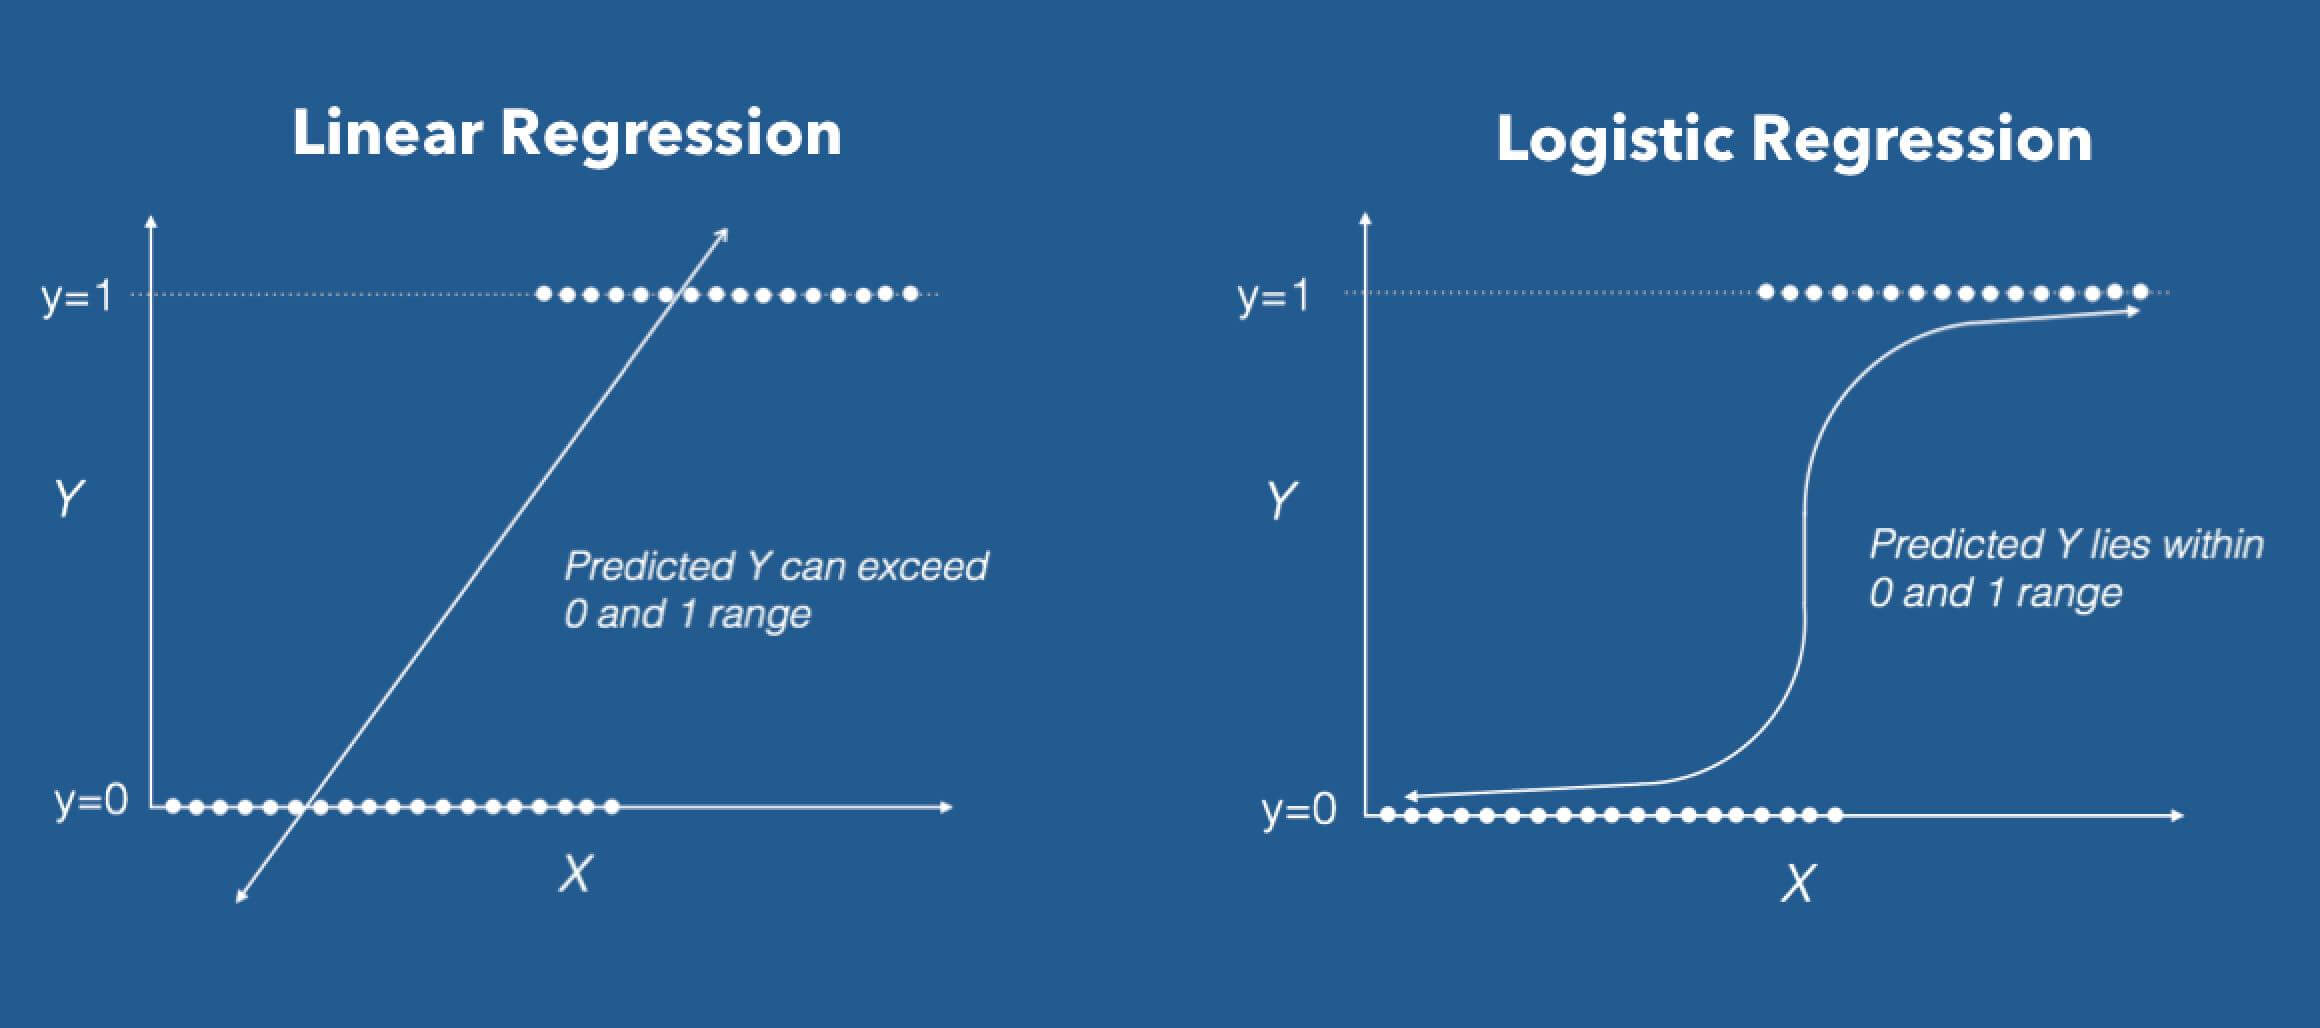

In [ ]:
logreg_basic= sk_lm.LogisticRegression()
parameters = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'max_iter': np.arange(100, 401, 100),
              'C': np.arange(0.4, 1.7, 0.2)}
clf_logreg = GridSearchCV(logreg_basic, parameters, verbose=3, cv=3, scoring='accuracy', n_jobs=-1, refit=False).fit(X_train, y_train_binary)
print(f"Best params: {clf_logreg.best_params_}")

Fitting 3 folds for each of 140 candidates, totalling 420 fits
Best params: {'C': 0.8000000000000002, 'max_iter': 400, 'solver': 'lbfgs'}


In [ ]:
start=time.time()
logreg = sk_lm.LogisticRegression(C= 0.8, max_iter= 500, solver= 'lbfgs').fit(X_train, y_train_binary) # lbfgs solver only supports l2 or none penalty.
stop=time.time()
y_predicted_logreg = logreg.predict(X_test)

print(pd.DataFrame(list(zip(y_test_binary, y_predicted_logreg)), columns = ['y_test', 'y_predicted']))
accuracy_logreg = sklm.accuracy_score(y_test_binary, y_predicted_logreg)
f1_logreg = sklm.f1_score(y_test_binary, y_predicted_logreg)
precision_logreg = sklm.precision_score(y_test_binary, y_predicted_logreg)
recall_logreg = sklm.recall_score(y_test_binary, y_predicted_logreg)
execution_time_logreg = round(stop-start, 3)

print(f'''\nAccuracy = {round(accuracy_logreg, 2)}
Precision = {round(precision_logreg, 2)}
Recall = {round(recall_logreg, 2)}
F1-Score = {round(f1_logreg, 2)}
Execution Time = {execution_time_logreg} sec''')

      y_test  y_predicted
0          1            1
1          1            0
2          1            1
3          1            1
4          1            1
...      ...          ...
7688       0            0
7689       1            1
7690       0            0
7691       0            0
7692       1            1

[7693 rows x 2 columns]

Accuracy = 0.65
Precision = 0.66
Recall = 0.7
F1-Score = 0.68
Execution Time = 4.379 sec


### Support Vector Classifier 🧇🛡️

Second model - SVC (or **Support Vector Classifier**) is a machine learning algorithm belonging to the Support Vector Machine (SVM) family. SVM algorithms use the **vector component of the dataset's samples** to determine a preferential orientation. More precisely, we plot each data item as a point in n-dimensional space (where n is a number of features you have) with the value of each feature being the value of a particular coordinate. Then, we perform classification by **finding the hyper-plane that differentiates** the two classes very well.

SVC has many advantages, such as:

*   **Effective in high dimensional spaces** and **very versatile** thanks to the different kernels available.

*   **Memory efficient**, by using a **subset** of training points in the decision function (called support vectors).

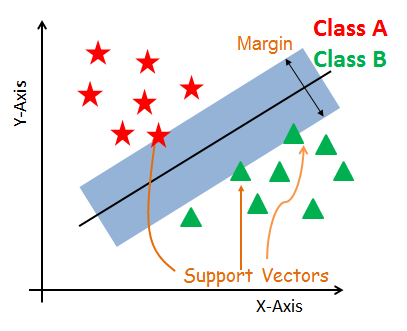

In [ ]:
svc_basic= SVC()
parameters = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'class_weight': ['balanced', None],
              'shrinking': [True, False]}
clf_svc = GridSearchCV(svc_basic, parameters, verbose=3, cv=3, scoring='accuracy', n_jobs=-1, refit=False).fit(X_train, y_train_binary)
print(f"Best params: {clf_svc.best_params_}")

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best params: {'class_weight': None, 'kernel': 'linear', 'shrinking': True}


In [ ]:
start=time.time()
svc = SVC(class_weight= None, kernel= 'linear', shrinking= True).fit(X_train, y_train_binary)
stop=time.time()
y_predicted_svc = svc.predict(X_test)

print(pd.DataFrame(list(zip(y_test_binary, y_predicted_svc)), columns = ['y_test', 'y_predicted']))
accuracy_svc = sklm.accuracy_score(y_test_binary, y_predicted_svc)
f1_svc = sklm.f1_score(y_test_binary, y_predicted_svc)
precision_svc = sklm.precision_score(y_test_binary, y_predicted_svc)
recall_svc = sklm.recall_score(y_test_binary, y_predicted_svc)
execution_time_svc = round(stop-start, 3)

print(f'''\nAccuracy = {round(accuracy_svc, 2)}
Precision = {round(precision_svc, 2)}
Recall = {round(recall_svc, 2)}
F1-Score = {round(f1_svc, 2)}
Execution Time = {execution_time_svc} sec''')

      y_test  y_predicted
0          1            0
1          1            0
2          1            1
3          1            1
4          1            1
...      ...          ...
7688       0            0
7689       1            0
7690       0            0
7691       0            0
7692       1            1

[7693 rows x 2 columns]

Accuracy = 0.66
Precision = 0.67
Recall = 0.69
F1-Score = 0.68
Execution Time = 295.369 sec


### Random Forest Classifier 〽️🌳

For our third model, we use one of the algorithms that obtain a sizable score with brute force technique: **Random Forest**. The Random Forest algorithm is an **ensemble method** for classification or regression based on **multiple learning decision trees** trained on **slightly different subsets** of data. 

Random Forest has many advantages, such as:

*   An excellent **trade-off between interpretability and efficiency**. This allows, for example, to determine **which features were decisive** for obtaining a prediction while remaining accurate.

*   Reduce the risk of error and **avoid overfitting** by considering different subsets (*low-correlated trees*).

However, one of the major drawbacks of Random Forest is that its **computations may go far more complex** compared to other algorithms. To deal with it, our strategy was to **slowly narrow the range of hyperparameters** and searching the number of trees afterwards.

cf. **crowd psychology**: an intelligence stronger than human intelligence emerges from a group of people.

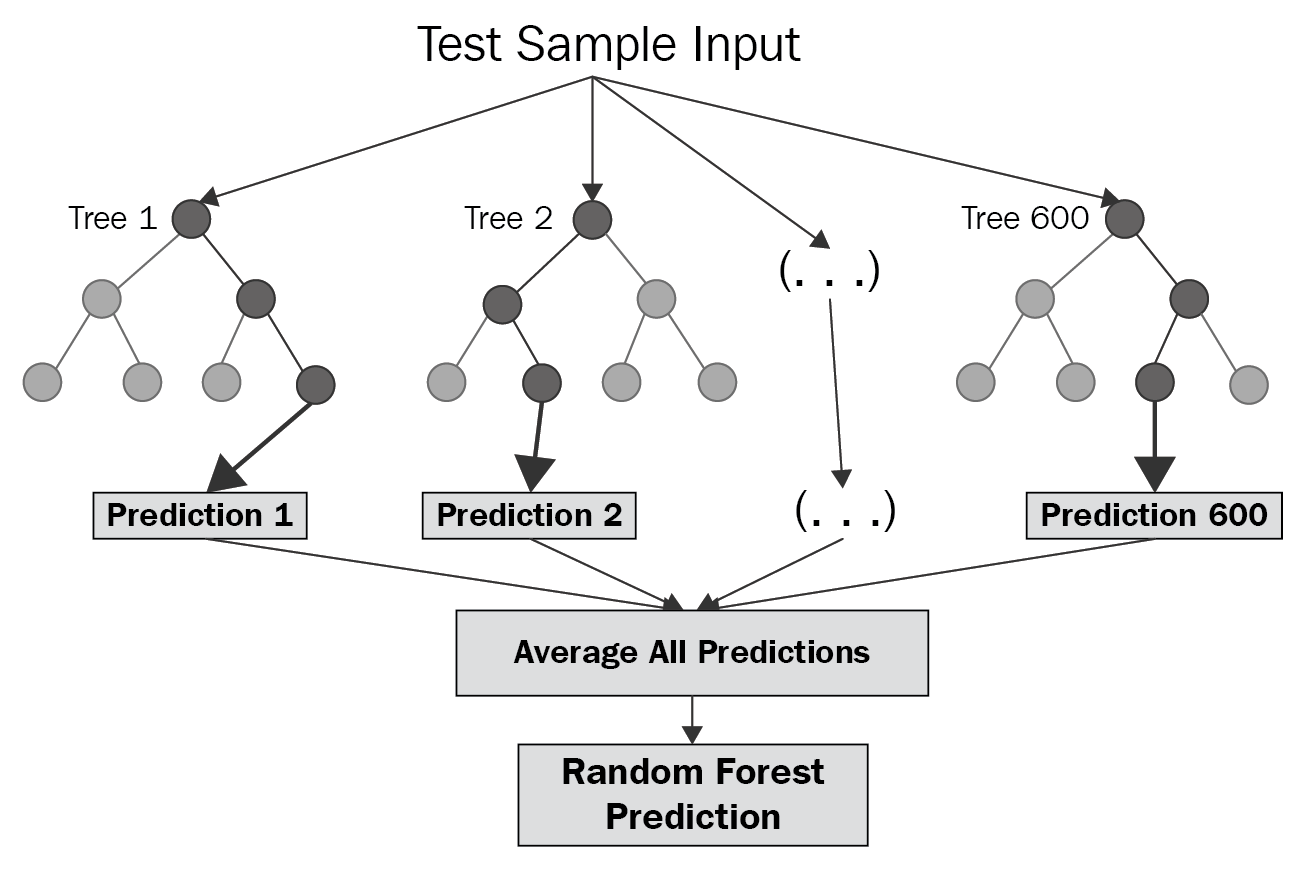

In [ ]:
rfg_basic = sk_en.RandomForestClassifier(n_jobs=-1)
parameters = {
              'n_estimators': list(np.arange(100, 501, 100)),
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_samples': np.arange(0.7, 1.1, 0.1),
              'max_depth': [None, 10, 20, 30, 40]}
clf_rfg = GridSearchCV(rfg_basic, parameters, verbose=3, cv=3, scoring='accuracy', n_jobs=-1, refit=False).fit(X_train, y_train_binary)
print(f"Best params: {clf_rfg.best_params_}\n")

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best params: {'max_depth': 40, 'n_estimators': 400}



In [ ]:
start=time.time()
rfg = sk_en.RandomForestClassifier(n_estimators= 400, max_depth= 40, max_features= 'sqrt',
                                   max_samples= 0.8, n_jobs=-1).fit(X_train, y_train_binary)
stop=time.time()
y_predicted_rfg = rfg.predict(X_test)

print(pd.DataFrame(list(zip(y_test_binary, y_predicted_rfg)), columns = ['y_test', 'y_predicted']))
accuracy_rfg = sklm.accuracy_score(y_test_binary, y_predicted_rfg)
f1_rfg = sklm.f1_score(y_test_binary, y_predicted_rfg)
precision_rfg = sklm.precision_score(y_test_binary, y_predicted_rfg)
recall_rfg = sklm.recall_score(y_test_binary, y_predicted_rfg)
execution_time_rfg = round(stop-start, 3)

print(f'''\nAccuracy = {round(accuracy_rfg, 2)}
Precision = {round(precision_rfg, 2)}
Recall = {round(recall_rfg, 2)}
F1-Score = {round(f1_rfg, 2)}
Execution Time = {execution_time_rfg} sec''')

      y_test  y_predicted
0          1            1
1          1            0
2          1            1
3          1            0
4          1            1
...      ...          ...
7688       0            0
7689       1            0
7690       0            0
7691       0            0
7692       1            0

[7693 rows x 2 columns]

Accuracy = 0.66
Precision = 0.66
Recall = 0.72
F1-Score = 0.69
Execution Time = 37.396 sec


### Light Gradient Boosted Machine 📈⚙️

In this section, we use a fast and powerful **gradient boosting framework** also based on multiple decision trees learning: **LGBM**. Gradient boosting is a method of turning **weak learners into strong ones**. It relies heavily on the idea that the prediction of the next tree within a model will reduce prediction errors when mixed with previous models. LGMB is a **recent model** that is **performing in Kaggle competitions**, with even better results than *NN* or *XGBoost* algorithms.

LGBM has many advantages, such as:

1.   **Trains faster** and is more efficient using **less memory**.

2.   **Very efficient** in general, with more complex trees via a **leaf-wise** growth approach (~*DFS*), even on large datasets.

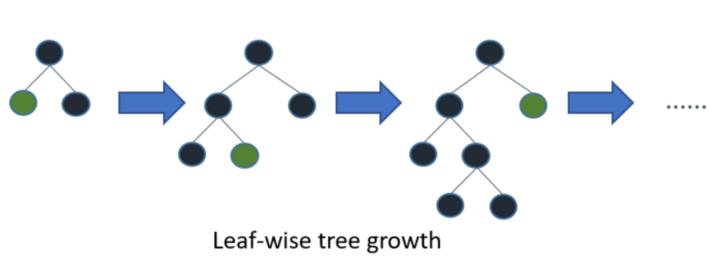

In [ ]:
lgb_basic = lgb.LGBMClassifier()
parameters = {
              'n_estimators': np.arange(100, 501, 100),
              'boosting_type': ['gbdt', 'goss', 'dart'],
              'learning_rate': np.arange(0.05, 0.1, 0.01),
              'colsample_bytree': np.arange(0.6, 1.1, 0.2),
              'max_depth': np.arange(20, 51, 10)}
clf_lgb = GridSearchCV(lgb_basic, parameters, verbose=3, cv=3, scoring='accuracy', n_jobs=-1, refit=False).fit(X_train, y_train_binary)
print(f"Best params: {clf_lgb.best_params_}\n")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best params: {'learning_rate': 0.08000000000000002, 'max_depth': 20, 'n_estimators': 100}



In [ ]:
start=time.time()
lgbm=lgb.LGBMClassifier(n_estimators= 100, boosting_type= 'gbdt', colsample_bytree= 0.8, learning_rate= 0.08, max_depth= 20).fit(X_train, y_train_binary)
stop=time.time()
y_predicted_lgbm= np.around(lgbm.predict(X_test), 1)

print(pd.DataFrame(list(zip(y_test_binary, y_predicted_lgbm)), columns = ['y_test', 'y_predicted']))
accuracy_lgbm = sklm.accuracy_score(y_test_binary, y_predicted_lgbm)
f1_lgbm = sklm.f1_score(y_test_binary, y_predicted_lgbm)
precision_lgbm = sklm.precision_score(y_test_binary, y_predicted_lgbm)
recall_lgbm = sklm.recall_score(y_test_binary, y_predicted_lgbm)
execution_time_lgbm = round(stop-start, 3)

print(f'''\nAccuracy = {round(accuracy_lgbm, 2)}
Precision = {round(precision_lgbm, 2)}
Recall = {round(recall_lgbm, 2)}
F1-Score = {round(f1_lgbm, 2)}
Execution Time = {execution_time_lgbm} sec''')

      y_test  y_predicted
0          1            1
1          1            0
2          1            1
3          1            0
4          1            1
...      ...          ...
7688       0            0
7689       1            0
7690       0            0
7691       0            0
7692       1            0

[7693 rows x 2 columns]

Accuracy = 0.67
Precision = 0.68
Recall = 0.73
F1-Score = 0.7
Execution Time = 1.455 sec


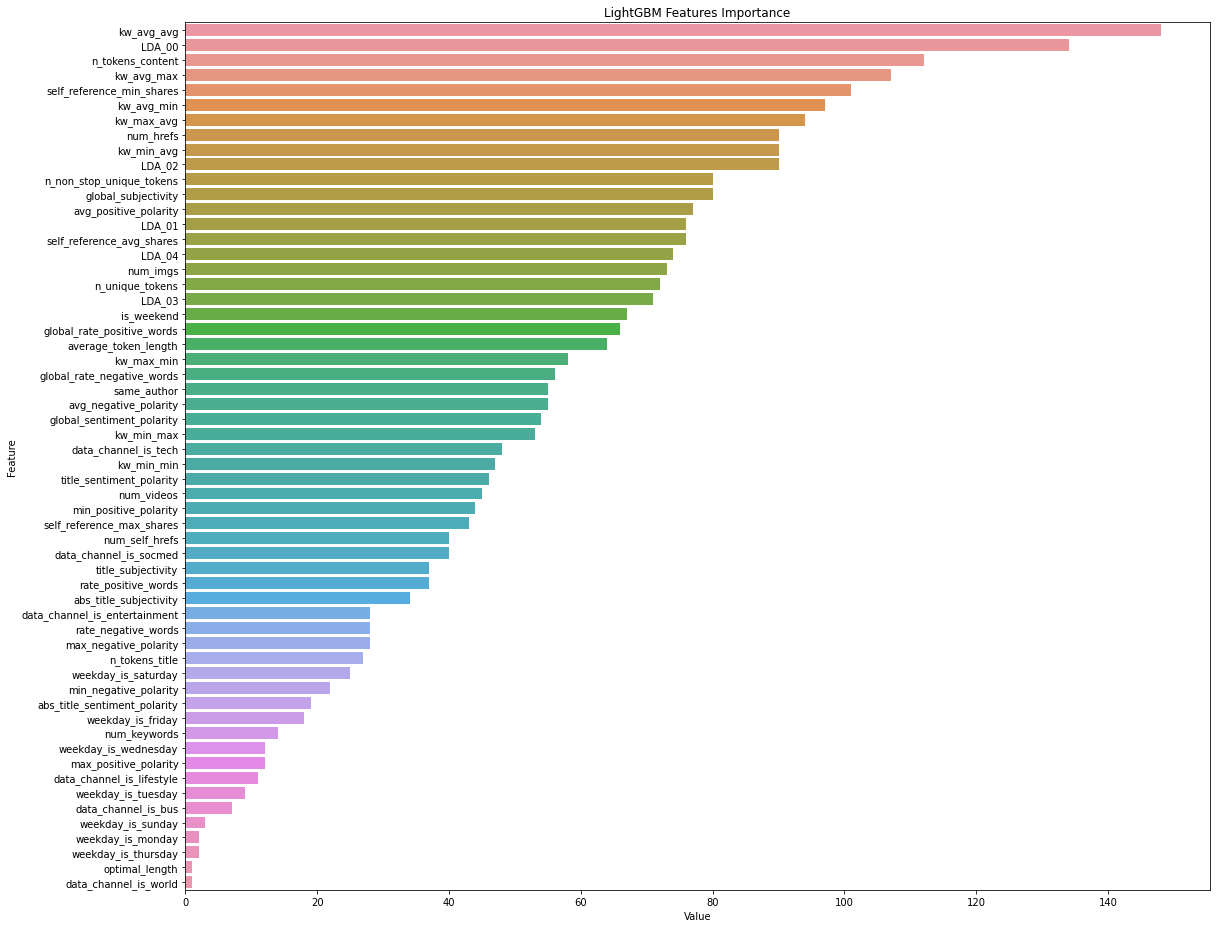

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(17, 13))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features Importance')
plt.tight_layout()
plt.show()

### Neural Network 🧿☄️

A **neural network** is an algorithmic model composed of s**everal layers of computational units**, called neurons. Each neuron receives as input the outputs of the previous neuron while **continuously adjusting the weights** given to the values thanks to an error **back-propagation system**. Here our neural network doesn't need to be too complex: an **input layer** leading to **3 hidden layers** with the *relu* activation function + a **dropout layer** and **2-neurons-layer output** with *sigmoid* AF. Our compiler is made of **Adam optimizer** linked with a **binary_crossentropy loss** function and accuracy metric.

Fully-connected neural networks, as we have here, has many advantages, such as:

*   **Store information** on the entire network, allowing to **work with incomplete knowledge**.
*   Have a **distributed memory** while having a **important numerical strength** that can perform more than one job at the same time and is **fault tolerant**. 

However, it is crucial to take into account the drawbacks of such algorithms such as the **hardware dependance** (leading to high computationnal time) and especially the **risk of overfitting**. To deal with it, we **split** our training set **into training and validation sets**. Validation set that we use to measure the **accuracy on a unknown set** (*val_accuracy*).

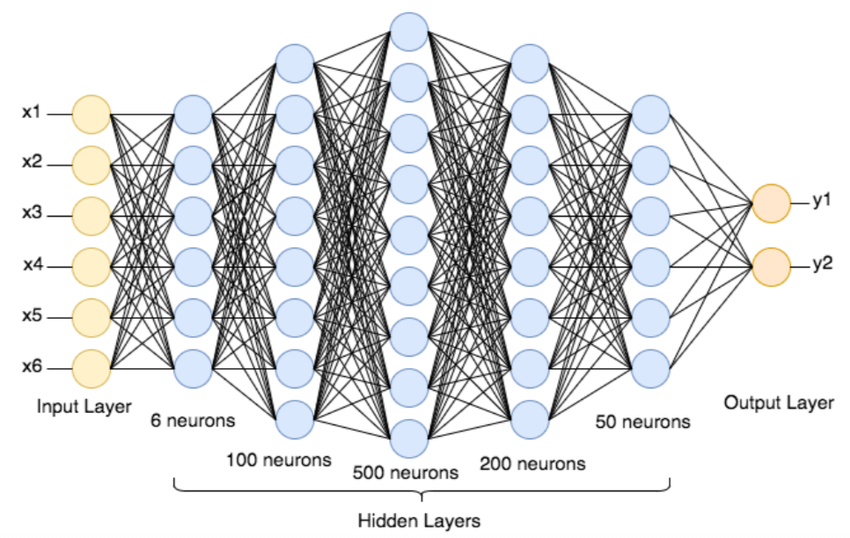

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.20, random_state = 50)

In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(6, activation='relu', input_dim=X_train.shape[1]),
                             tf.keras.layers.Dense(100, activation='relu'),
                             tf.keras.layers.Dense(500, activation='relu'),
                             tf.keras.layers.Dropout(0.1),
                             tf.keras.layers.Dense(200, activation='relu'),
                             tf.keras.layers.Dense(50, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 354       
                                                                 
 dense_1 (Dense)             (None, 100)               700       
                                                                 
 dense_2 (Dense)             (None, 500)               50500     
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 50)                10050     
                                                                 
 dense_5 (Dense)             (None, 1)                 5

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
start=time.time()
model.fit(X_train, y_train, epochs = 20, validation_data=(X_validation, y_validation))
stop=time.time()

Epoch 1/20
705/705 [==============================] - 8s 9ms/step - loss: 0.6551 - accuracy: 0.6167 - val_loss: 0.6331 - val_accuracy: 0.6521
Epoch 2/20
705/705 [==============================] - 6s 8ms/step - loss: 0.6319 - accuracy: 0.6430 - val_loss: 0.6243 - val_accuracy: 0.6600
Epoch 3/20
705/705 [==============================] - 6s 8ms/step - loss: 0.6246 - accuracy: 0.6547 - val_loss: 0.6216 - val_accuracy: 0.6583
Epoch 4/20
705/705 [==============================] - 6s 9ms/step - loss: 0.6204 - accuracy: 0.6550 - val_loss: 0.6183 - val_accuracy: 0.6608
Epoch 5/20
705/705 [==============================] - 7s 11ms/step - loss: 0.6175 - accuracy: 0.6591 - val_loss: 0.6228 - val_accuracy: 0.6565
Epoch 6/20
705/705 [==============================] - 6s 8ms/step - loss: 0.6157 - accuracy: 0.6600 - val_loss: 0.6180 - val_accuracy: 0.6545
Epoch 7/20
705/705 [==============================] - 8s 11ms/step - loss: 0.6135 - accuracy: 0.6605 - val_loss: 0.6153 - val_accuracy: 0.6643
Epoc

In [ ]:
y_predicted_probas = model.predict(X_test)
y_predicted_nn = np.round(y_predicted_probas, 0)

print(pd.DataFrame(list(zip(y_test_binary, y_predicted_nn)), columns = ['y_test', 'y_predicted']))
accuracy_nn = sklm.accuracy_score(y_test_binary, y_predicted_nn)
f1_nn = sklm.f1_score(y_test_binary, y_predicted_nn)
precision_nn = sklm.precision_score(y_test_binary, y_predicted_nn)
recall_nn = sklm.recall_score(y_test_binary, y_predicted_nn)
execution_time_nn = round(stop-start, 3)

print(f'''\nAccuracy = {round(accuracy_nn, 2)}
Precision = {round(precision_nn, 2)}
Recall = {round(recall_nn, 2)}
F1-Score = {round(f1_nn, 2)}
Execution Time = {execution_time_nn} sec''')

      y_test y_predicted
0          1       [0.0]
1          1       [0.0]
2          1       [1.0]
3          1       [0.0]
4          1       [1.0]
...      ...         ...
7688       0       [0.0]
7689       1       [0.0]
7690       0       [0.0]
7691       0       [0.0]
7692       1       [1.0]

[7693 rows x 2 columns]

Accuracy = 0.65
Precision = 0.66
Recall = 0.69
F1-Score = 0.67
Execution Time = 144.088 sec


## Performance Comparisons 🪓🎲

In [ ]:
comparison_dict = {'Accuracy':(accuracy_lgbm, accuracy_logreg, accuracy_rfg, accuracy_nn, accuracy_svc),
                   'Precision':(precision_lgbm, precision_logreg, precision_rfg, precision_nn, precision_svc),
                   'Recall':(recall_lgbm, recall_logreg, recall_rfg, recall_nn, recall_svc),
                   'F1-Score':(f1_lgbm, f1_logreg, f1_rfg, f1_nn, f1_svc),
                   'Exec Time (sec)':(execution_time_lgbm, execution_time_logreg, execution_time_rfg, execution_time_nn, execution_time_svc)}

comparison_df = pd.DataFrame(comparison_dict) 
comparison_df.index= ['LightGBM', 'Logistic Regression', 'Random Forest Class', 'Neural Network', 'SVC'] 
comparison_df

Accuracy  Precision    Recall  F1-Score  Exec Time (sec)
LightGBM             0.671000   0.675075  0.721316  0.697430            1.249
Logistic Regression  0.651631   0.659569  0.697082  0.677807            4.379
Random Forest Class  0.662940   0.664624  0.724283  0.693172           37.396
Neural Network       0.649812   0.659877  0.688922  0.674087          144.088
SVC                  0.655401   0.665400  0.692878  0.678861          295.369

In [ ]:
fig = go.Figure()
colors = ['cornflowerblue', 'dodgerblue', 'steelblue', 'lightskyblue', 'royalblue']
fig.add_trace(go.Bar(x=comparison_df.index, y=comparison_df['Accuracy'], marker_color=colors,
                     hovertext=comparison_df['Exec Time (sec)'], opacity=0.7, name='Accuracy - Exec Time'))

fig.add_trace(go.Scatter(x=comparison_df.index, y=comparison_df['Precision'],
                         mode='markers + lines', name='Precision', marker_color='darkred'))
fig.add_trace(go.Scatter(x=comparison_df.index, y=comparison_df['Recall'],
                         mode='markers + lines', name='Recall', marker_color='darkorange'))
fig.add_trace(go.Scatter(x=comparison_df.index, y=comparison_df['F1-Score'],
                         mode='markers + lines', name='F1-Score', marker_color='gold'))
fig.update_layout(title='Performance Comparison Graph')
fig.show()

As expected and announced by the brute force testing, **LightGBM is clearly superior** to the other models, reaching a average of **70% for all metrics** in only **1.2 seconds** ! This is *3 times* faster than Logistic Regression and *~250 times* faster than SVC.

In a world where everything is going faster, **obtaining quick results** from that kind of problem is crucial. And this is why LGBM is **one of the most used algorithms** today !

## Regression Exploration with MLR 🔥🔍

In the research paper, the authors wanted to predict whether an article was likely to be **successful or not**. In consequence, they set a **threshold to 1400** over which the article was considered popular. However, we thought that 1400 was **quite subjective**, even based on the number of Mashable users at that time, and we **aimed for a model as general as possible**.

Thus, our first objective was to **predict the number of shares** an article will receive after its publication **nuanced by its _timedelta_**(days passed since the article publication).

To do so we consider the multiple linear regression model from *sklearn.linear_model* library **LinearRegression**. By definition, multiple linear regression is a mathematical regression method that extends simple linear regression to **describe a target variations** depending on **several predictors variations**.  

Linear Regression **has the advantage** of allowing a more accurate understanding of the **relative influence** of one or more predictors on the target variable as well as the **relationship between the different predictors** themselves. However, linear regression is also very **sensible to collinearity** of the data and **outliers** hence the importance of **robust-scalling**.

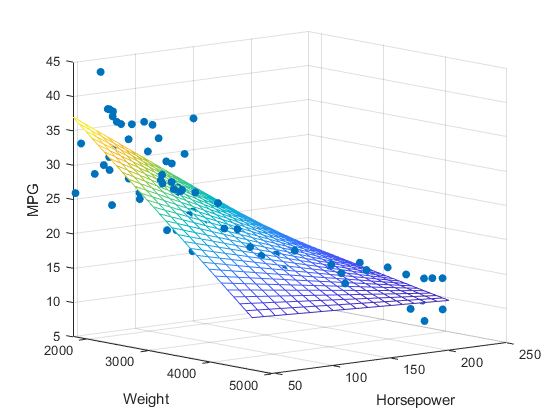

In [ ]:
start=time.time()
multi_lin_reg = sk_lm.LinearRegression().fit(X_train, y_train)
stop=time.time()
y_predicted_mlr = np.around(multi_lin_reg.predict(X_test), 1)

print(pd.DataFrame(list(zip(y_test, y_predicted_mlr)), columns = ['y_test', 'y_predicted']))
mse_mlr = sklm.mean_squared_error(y_test, y_predicted_mlr)
r2_mlr = sklm.r2_score(y_test, y_predicted_mlr)
execution_time_mlr = round(stop-start, 3)
print(f'\nMSE = {round(mse_mlr, 2)}\nR Squared = {r2_mlr}\nExecution Time = {execution_time_mlr} sec')

         y_test  y_predicted
0      7.600902          7.4
1      7.244228          7.1
2      7.313220          7.8
3     10.177324          7.5
4      8.268732          7.7
...         ...          ...
7688   6.867974          7.2
7689   7.549609          7.5
7690   6.486161          7.1
7691   6.498282          7.1
7692   8.496990          7.5

[7693 rows x 2 columns]

MSE = 0.79
R Squared = 0.060343540746740865
Execution Time = 0.09 sec


As we can see, we have **R² close to 0**. Cleary meaning that our model **isn't representing the data** at all. The problem is still there even after **treating the outliers** that we know some models are sensible to, and **applying a logarithm** to normalize the shares distribution’s curve.

This can be explained by the fact that the *timedelta* is the **only information about the temporality** of the article and depending on the time passed since its publication, 2 articles with the same characteristics may have completely different share scores. The number of shares can be exponential and **rise extremely fast** from one day to another. This also brings the **luck factor** that can't be denied when you talk about popularity. Indeed, you only need the right person at the right time to share your article somewhere, to see it going from 217 shares to 4000 overnight.

Also it is important to consider that the number of shares **not only depends on the content and its author** (promotion on social medias, famous ?) but also **on the plateform**. Mashable in 2013 is clearly not the same as Mashable in 2014. **The website changes and its popularity too**, as you can see below. Thus, you have **stand back** from the raw dataset and **adapt your predictions** !

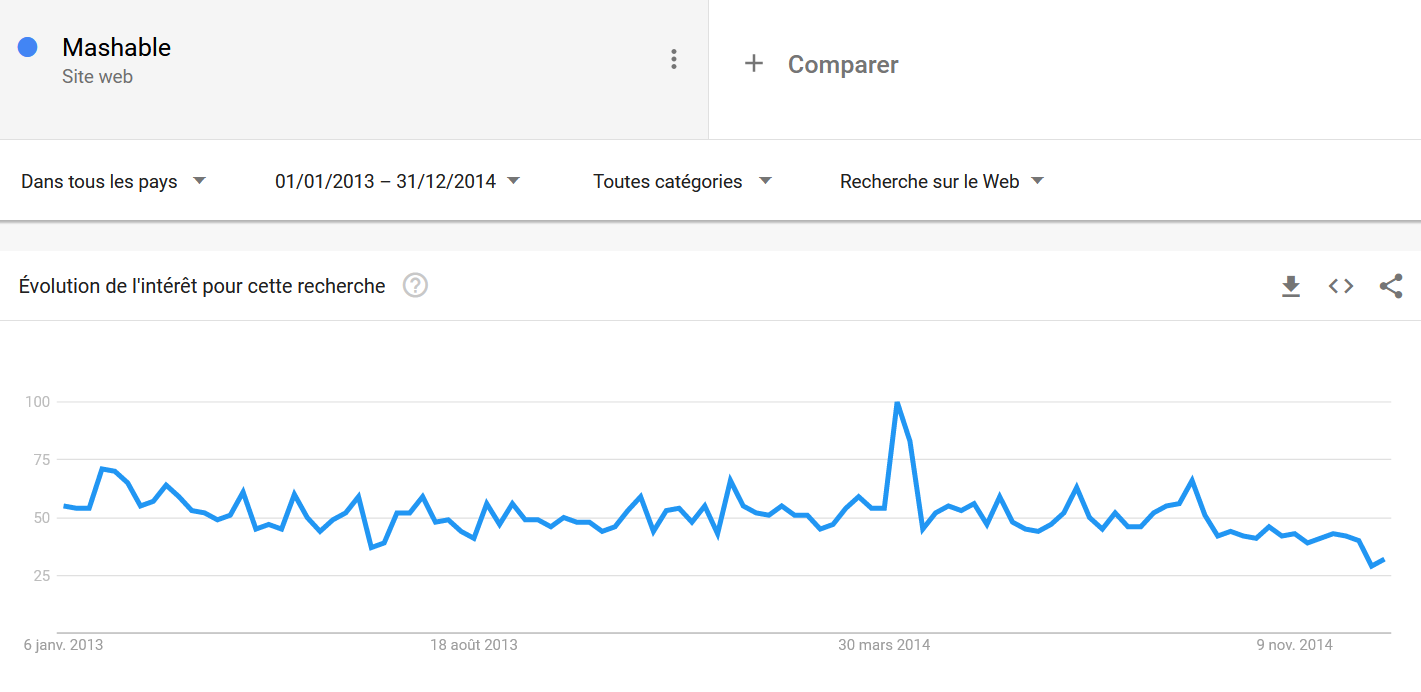